In [1]:
import pandas as pd
import numpy as np

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize

import matplotlib as mpl
mpl.rcParams['font.size'] = 18

import matplotlib.lines as mlines

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import itertools

In [3]:
import pymc3 as pm
from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [30]:
def plot_trace(trace):
    ax = pm.traceplot(trace, figsize=(12, len(trace.varnames)*1.5),
                      lines={k: v['50%'] for k, v in pm.df_summary(trace).iterrows()})
    
    for i, mn in enumerate(pm.df_summary(trace)['50%']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data',
                          xytext = (5, 10), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')
        

In [220]:
def plot_confusion_matrix(cm, classes,
                          title='Diabetes Confusion matrix',
                          cmap=plt.cm.Reds):
    
    
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

# Load in Data

We are using the [Pima Indians diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database). The objective is a binary classification model that predicts whether or not an individual has diabetes based on several indicators.

In [4]:
data = pd.read_csv('data/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
features = data.drop(columns='Outcome')
labels = data.Outcome

X, X_test, y, y_test = train_test_split(features, labels, test_size=200)

In [19]:
formula = [' %s + ' % variable for variable in X.columns]
formula.insert(0, 'y ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'y ~  Pregnancies +  Glucose +  BloodPressure +  SkinThickness +  Insulin +  BMI +  DiabetesPedigreeFunction +  Age'

# Logistic Model

In [28]:
X_with_labels = X.copy()
X_with_labels['y'] = y

In [23]:
with pm.Model() as logistic_model:
    # Create the model using the formula
    pm.glm.GLM.from_formula(formula, data = X_with_labels, family = pm.glm.families.Binomial())
    
    sampler = pm.NUTS()
    
    # Sample from the posterior using NUTS
    trace_log = pm.sample(draws=5000, step = sampler, chains=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Age, DiabetesPedigreeFunction, BMI, Insulin, SkinThickness, BloodPressure, Glucose, Pregnancies, Intercept]


# Interpret Results

## Traceplot of Sampled Variables

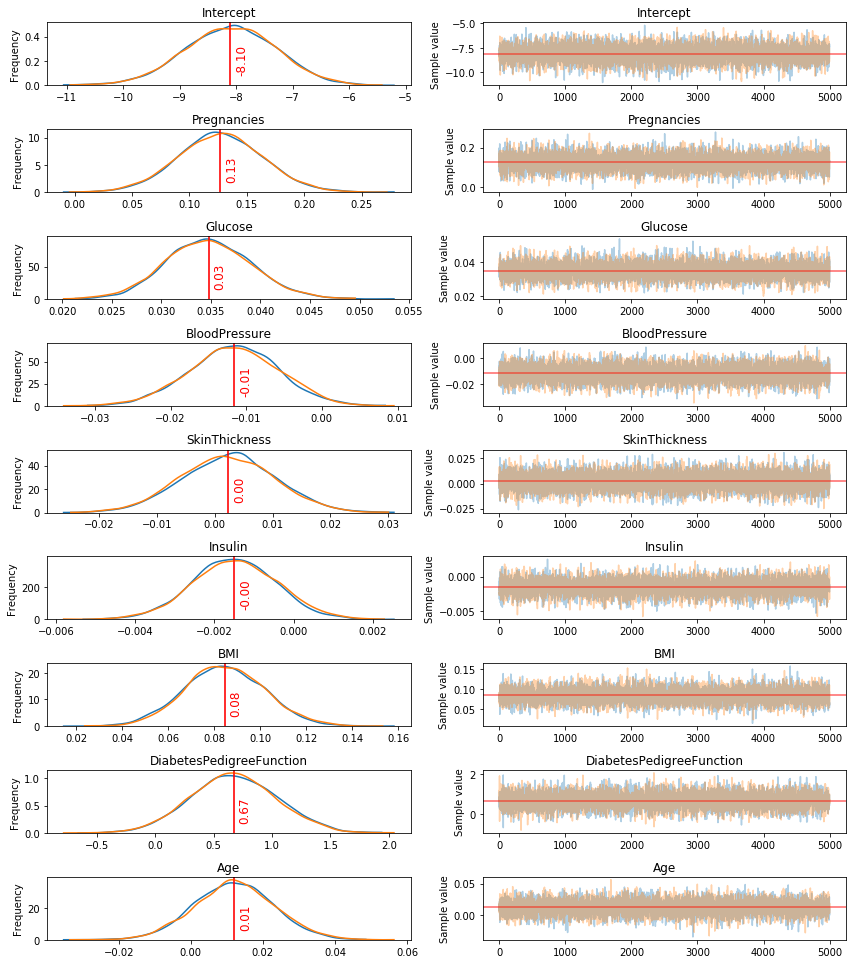

In [31]:
plot_trace(trace_log)

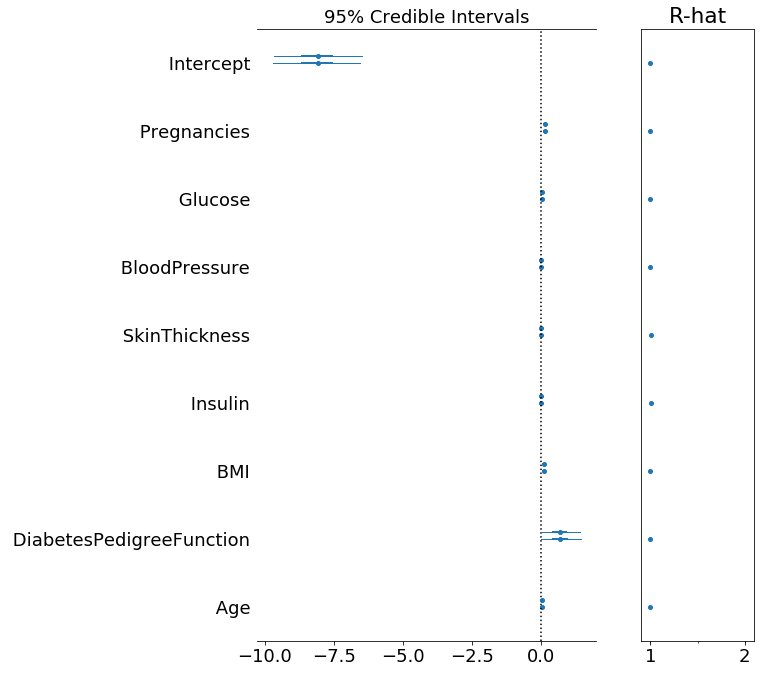

In [124]:
pm.forestplot(trace_log);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F088936400>,
      dtype=object)

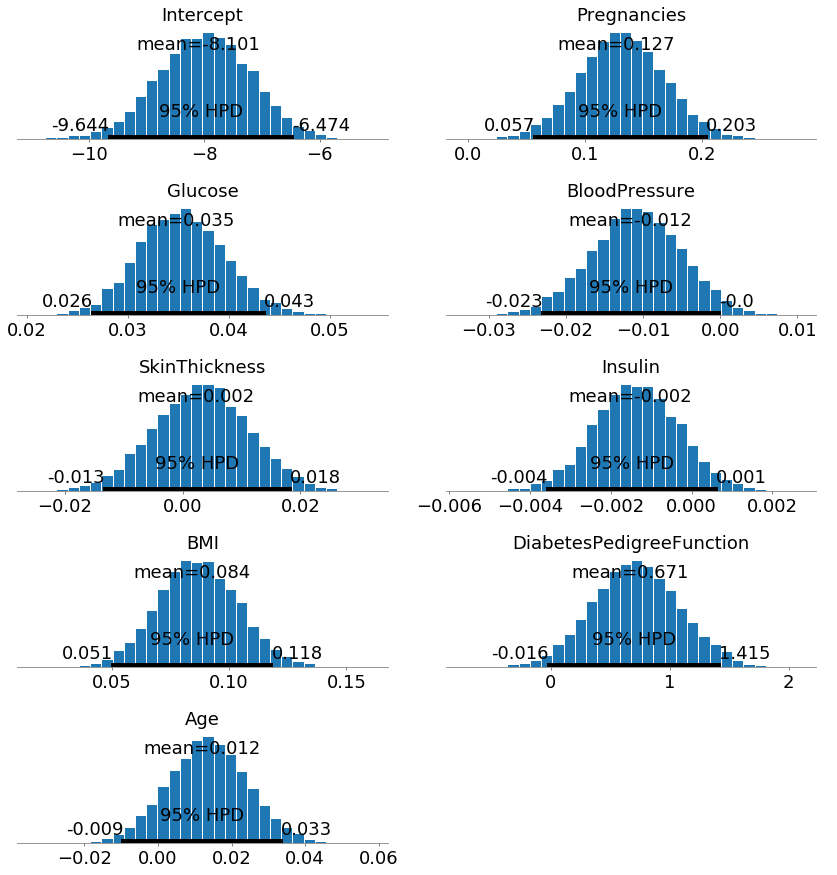

In [123]:
pm.plot_posterior(trace_log);

In [95]:
def evaluate_trace(trace, data, print_model = False):
    means_dict = {}
    std_dict = {}
    
    for var in trace.varnames:
        means_dict[var] = np.mean(trace[var])
        std_dict[var] = np.std(trace[var])
    
    model = 'y = %0.4f + ' % np.mean(means_dict['Intercept'])
    
    for var in data.columns:
        model += '%0.4f * %s + ' % (means_dict[var], var)
    
    model = ' '.join(model.split(' ')[:-2])
    if print_model:
        print('Final Equation: \n{}'.format(model))
    
    return means_dict, std_dict

In [96]:
means_dict, std_dict = evaluate_trace(trace_log, X, print_model=True)

Final Equation: 
y = -8.1007 + 0.1266 * Pregnancies + 0.0348 * Glucose + -0.0116 * BloodPressure + 0.0023 * SkinThickness + -0.0015 * Insulin + 0.0845 * BMI + 0.6710 * DiabetesPedigreeFunction + 0.0120 * Age


In [157]:
def find_probs(trace, data):
    
    means_dict, std_dict = evaluate_trace(trace, data)
    
    probs = []
    
    mean_array = np.array(list(means_dict.values()))
    
    data['Intercept'] = 1
    data = data[list(means_dict.keys())]
    
    for _, row in data.iterrows():
        logit = np.dot(row, mean_array)
        probability = 1 / (1 + np.exp(-logit))
        probs.append(probability)
        
    return probs

In [163]:
probs = find_probs(trace_log, X_test)
predictions = (np.array(probs) > 0.5)
accuracy = np.mean(predictions == y_test)
f1_metric = f1_score(y_test, predictions)

print('Accuracy of Model: {:.2f}%'.format(100 * accuracy))
print('F1 Score of Model: {:.4f}'.format(f1_metric))

Accuracy of Model: 77.50%
F1 Score of Model: 0.6565


Confusion matrix
[[112  13]
 [ 32  43]]


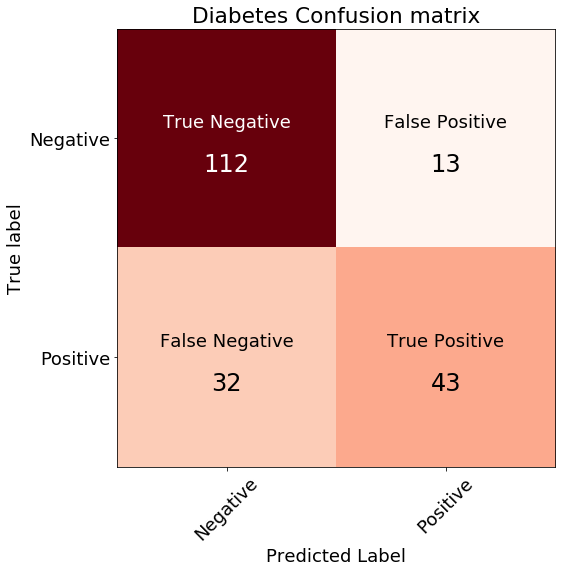

In [222]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['Negative', 'Positive'])

# Model Effects of Variables

In [154]:
def model_effect(query_var, trace, X):
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    def lm(x, samples):
        denominator = samples['Intercept'] + samples[query_var] * x
        
        for var in steady_vars:
            denominator += samples[var] * X.describe().ix['50%', var]
        denominator = (1 + np.exp(-denominator))
        probs = 1 / denominator 
        
        return probs
    
    figsize(12, 10)
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                 lm=lm, samples=100, color='blue', alpha = 0.4, lw = 2)
    
    plt.xlabel('%s' % query_var)
    plt.ylabel('P(Diabetes)')
    plt.title("Posterior Probability")
    plt.show()

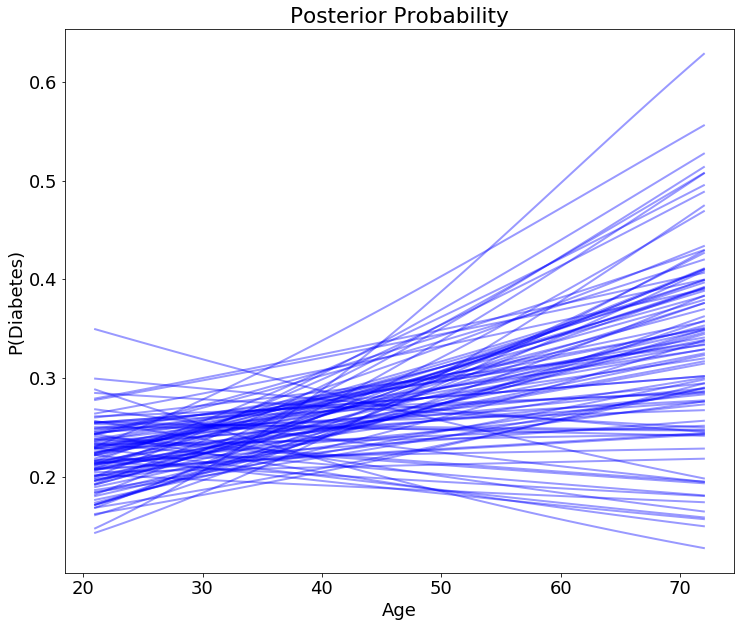

In [155]:
model_effect('Age', trace_log, X)

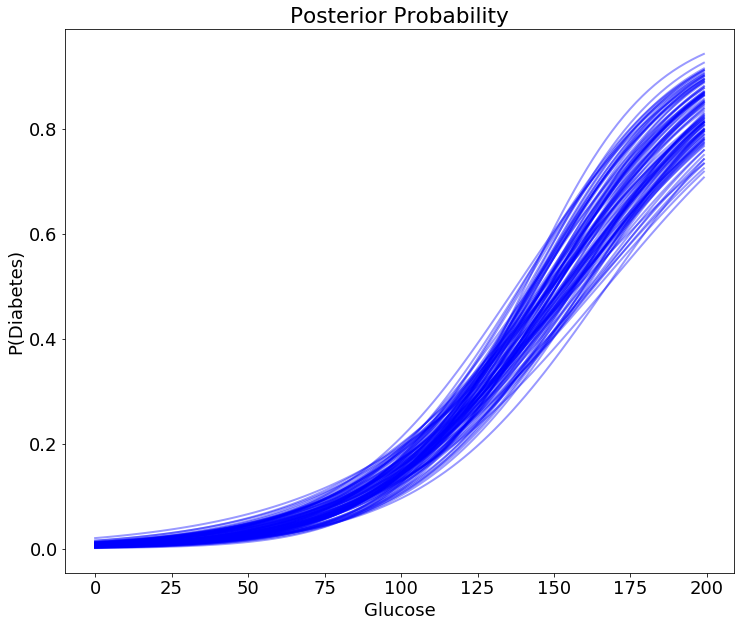

In [156]:
model_effect('Glucose', trace_log, X)

# Credible Interval

In [243]:
def get_credible_interval(trace, data_point, n_samples=1000):
    
    var_dict = {}
    for var in trace.varnames:
        var_dict[var]= trace[var][-n_samples:]
    
    var_list = list(var_dict.keys())
    data_point['Intercept'] = 1
    data_point = data_point[var_list]
    
    logits = np.dot(data_point.values, np.array(list(var_dict.values())))
    probs = 1 / (1 + np.exp(-logits))
    
    return(probs)

In [252]:
prob1 = get_credible_interval(trace_log, data_point = X_test.ix[1, :], n_samples=100)

In [254]:
X_test.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Intercept'],
      dtype='object')

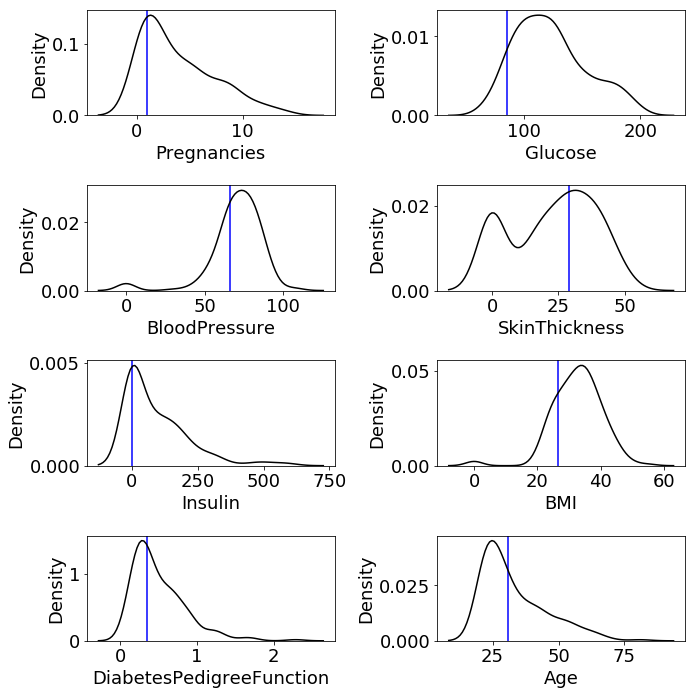

In [264]:
figsize(10, 10)
for i, var in enumerate(X_test.columns[:-1]):
    ax = plt.subplot(4, 2, i + 1)
    if var != 'Intercept':
        sns.kdeplot(X_test[var], color = 'black')
        plt.vlines(x = X_test.ix[1, var], ymin = 0, ymax = 100, colors = ['blue'])
        ax.set_xlabel(var)
        ax.set_ylabel('Density')
        ax.legend_.remove()
        

plt.tight_layout()
plt.show();

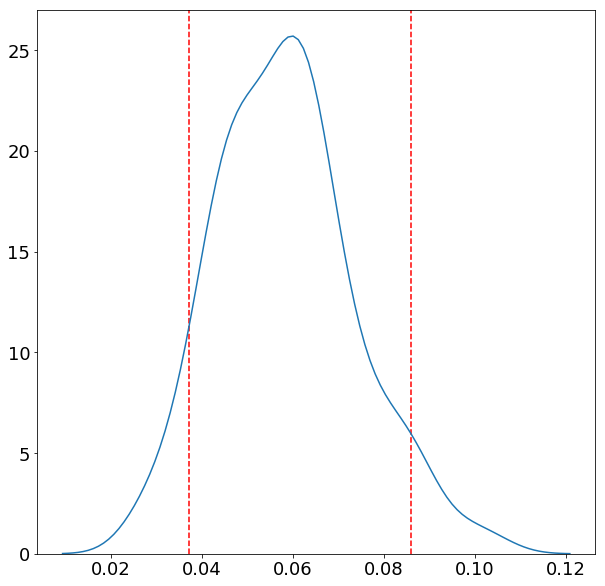

In [265]:
s = sns.kdeplot(prob1)
plt.vlines([np.percentile(prob1, 5), np.percentile(prob1, 95)], ymin = 0, ymax = 100,  colors = ['red'], linestyles = '--');